# Wind and Sea Level Pressure Interpolation
จากลิงก์ https://unidata.github.io/MetPy/latest/examples/gridding/Wind_SLP_Interpolation.html#

In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from metpy.calc import wind_components
from metpy.cbook import get_test_data
from metpy.interpolate import interpolate_to_grid, remove_nan_observations
from metpy.plots import add_metpy_logo
from metpy.units import units

to_proj = ccrs.AlbersEqualArea(central_longitude=-97., central_latitude=38.)

In [3]:
#Read in data
with get_test_data('station_data.txt') as f:
    data = pd.read_csv(f, header=0, usecols=(2, 3, 4, 5, 18, 19),
                       names=['latitude', 'longitude', 'slp', 'temperature', 'wind_dir',
                              'wind_speed'],
                       na_values=-99999)


In [4]:
#Project the lon/lat locations to our final projection
lon = data['longitude'].values
lat = data['latitude'].values
xp, yp, _ = to_proj.transform_points(ccrs.Geodetic(), lon, lat).T

In [5]:
#Remove all missing data from pressure

x_masked, y_masked, pressure = remove_nan_observations(xp, yp, data['slp'].values)

In [6]:
#Remove all missing data from pressure

slpgridx, slpgridy, slp = interpolate_to_grid(x_masked, y_masked, pressure,
                                              interp_type='cressman', minimum_neighbors=1,
                                              search_radius=400000, hres=100000)

In [7]:
#Get wind information and mask where either speed or direction is unavailable
wind_speed = (data['wind_speed'].values * units('m/s')).to('knots')
wind_dir = data['wind_dir'].values * units.degree

good_indices = np.where((~np.isnan(wind_dir)) & (~np.isnan(wind_speed)))

x_masked = xp[good_indices]
y_masked = yp[good_indices]
wind_speed = wind_speed[good_indices]
wind_dir = wind_dir[good_indices]


In [8]:
#Calculate u and v components of wind and then interpolate both.

u, v = wind_components(wind_speed, wind_dir)

windgridx, windgridy, uwind = interpolate_to_grid(x_masked, y_masked, np.array(u),
                                                  interp_type='cressman', search_radius=400000,
                                                  hres=100000)

_, _, vwind = interpolate_to_grid(x_masked, y_masked, np.array(v), interp_type='cressman',
                                  search_radius=400000, hres=100000)

In [9]:
#Get temperature information

x_masked, y_masked, t = remove_nan_observations(xp, yp, data['temperature'].values)
tempx, tempy, temp = interpolate_to_grid(x_masked, y_masked, t, interp_type='cressman',
                                         minimum_neighbors=3, search_radius=400000, hres=35000)

temp = np.ma.masked_where(np.isnan(temp), temp)

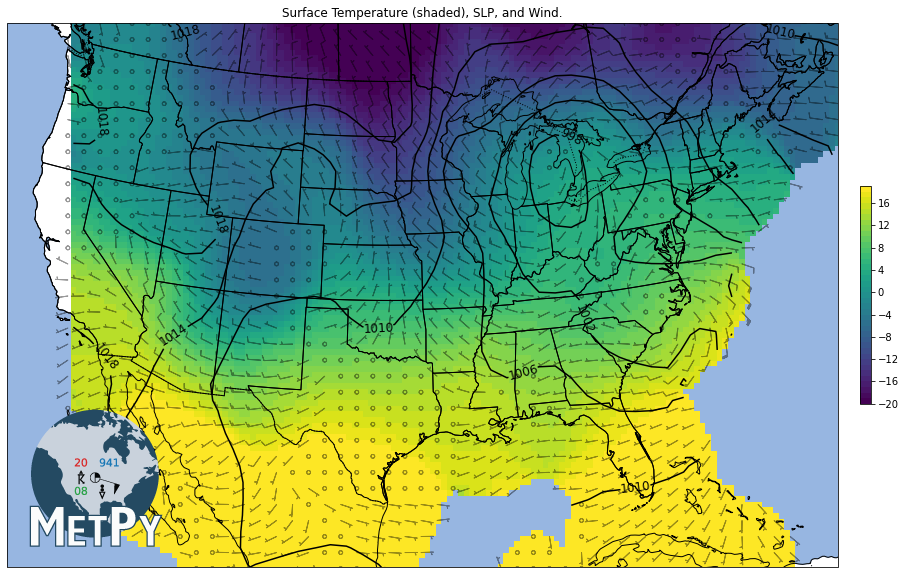

In [10]:
#Set up the map and plot the interpolated grids appropriately.
levels = list(range(-20, 20, 1))
cmap = plt.get_cmap('viridis')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig = plt.figure(figsize=(20, 10))
add_metpy_logo(fig, 20, 20, size='large')
view = fig.add_subplot(1, 1, 1, projection=to_proj)

view.set_extent([-120, -70, 20, 50])
view.add_feature(cfeature.STATES.with_scale('50m'))
view.add_feature(cfeature.OCEAN)
view.add_feature(cfeature.COASTLINE.with_scale('50m'))
view.add_feature(cfeature.BORDERS, linestyle=':')

cs = view.contour(slpgridx, slpgridy, slp, colors='k', levels=list(range(990, 1034, 4)))
view.clabel(cs, inline=1, fontsize=12, fmt='%i')

mmb = view.pcolormesh(tempx, tempy, temp, cmap=cmap, norm=norm)
fig.colorbar(mmb, shrink=.4, pad=0.02, boundaries=levels)

view.barbs(windgridx, windgridy, uwind, vwind, alpha=.4, length=5)

view.set_title('Surface Temperature (shaded), SLP, and Wind.')

plt.show()
